In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime as dt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.dates as mdates


**Читаем данные из файла**

In [67]:
df_temperature = pd.read_csv('test.csv', index_col='Unnamed: 0')

In [68]:
df_temperature.sort_values(by='Date', ascending=False)

,Date,Morning temperature,Daily temperature,Evening temperature,Night temperature
1602,2025-04-05,2,3,2,0
1585,2025-04-04,4,18,11,3
1568,2025-04-03,1,18,12,1
1551,2025-04-02,7,15,11,9
1534,2025-04-01,8,12,12,9
...,...,...,...,...,...
2039,2008-05-01,9,14,10,9
2022,2008-04-30,9,12,10,8
2005,2008-04-29,12,14,8,5
1988,2008-04-28,8,19,13,9


Проверяем есть ли nan значения, а также типы данных в стобцах

In [69]:
df_temperature.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6188 entries, 0 to 6187
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Date                 6188 non-null   object
 1   Morning temperature  6188 non-null   int64 
 2   Daily temperature    6188 non-null   int64 
 3   Evening temperature  6188 non-null   int64 
 4   Night temperature    6188 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 290.1+ KB


Создаем столбец "Year" для дальнейшей визуализации

In [70]:
df_temperature['Year'] = pd.to_datetime(df_temperature['Date']).dt.year
df_temperature['YM'] = pd.to_datetime(df_temperature['Date']).dt.strftime('%Y-%m')
df_temperature['Month'] = pd.to_datetime(df_temperature['Date']).dt.month

In [71]:
df_temperature

,Date,Morning temperature,Daily temperature,Evening temperature,Night temperature,Year,YM,Month
0,2025-01-01,2,3,4,3,2025,2025-01,1
1,2024-01-01,-1,-2,-4,-1,2024,2024-01,1
2,2023-01-01,6,9,8,6,2023,2023-01,1
3,2022-01-01,3,4,0,3,2022,2022-01,1
4,2021-01-01,2,1,1,2,2021,2021-01,1
...,...,...,...,...,...,...,...,...
6183,2012-12-31,1,1,1,-1,2012,2012-12,12
6184,2011-12-31,0,0,0,0,2011,2011-12,12
6185,2010-12-31,-5,-8,-7,-10,2010,2010-12,12
6186,2009-12-31,-7,-5,-5,-8,2009,2009-12,12


Строим график среднемесячной дневной температуры за последние три года

In [72]:
df_temperature_mean = (
    df_temperature
    .groupby('YM')
    .agg({'Daily temperature':'mean'})
    .reset_index()
)
df_temperature_mean['Daily temperature'] = df_temperature_mean['Daily temperature'].round(1)
df_temperature_mean['Year'] = pd.to_datetime(df_temperature_mean['YM']).dt.year
df_temperature_mean['Month'] = pd.to_datetime(df_temperature_mean['YM']).dt.month

In [73]:
df_temperature_mean

,YM,Daily temperature,Year,Month
0,2008-04,15.2,2008,4
1,2008-05,14.6,2008,5
2,2008-06,20.1,2008,6
3,2008-07,21.8,2008,7
4,2008-08,21.6,2008,8
...,...,...,...,...
200,2024-12,1.0,2024,12
201,2025-01,1.9,2025,1
202,2025-02,-1.5,2025,2
203,2025-03,8.9,2025,3


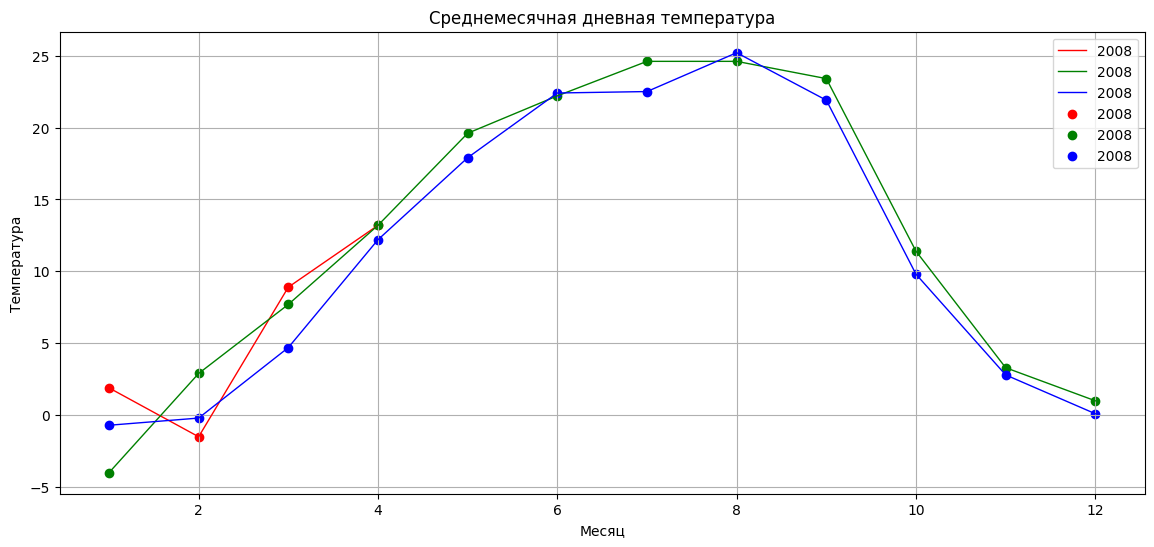

In [74]:
plt.figure(figsize=(14,6))
plt.plot(df_temperature_mean.loc[df_temperature_mean['Year']==2025, 'Month'], df_temperature_mean.loc[df_temperature_mean['Year']==2025, 'Daily temperature'], linewidth=1, color='red')
plt.plot(df_temperature_mean.loc[df_temperature_mean['Year']==2024, 'Month'], df_temperature_mean.loc[df_temperature_mean['Year']==2024, 'Daily temperature'], linewidth=1, color='green')
plt.plot(df_temperature_mean.loc[df_temperature_mean['Year']==2023, 'Month'], df_temperature_mean.loc[df_temperature_mean['Year']==2023, 'Daily temperature'], linewidth=1, color='blue')
plt.scatter(df_temperature_mean.loc[df_temperature_mean['Year']==2025, 'Month'], df_temperature_mean.loc[df_temperature_mean['Year']==2025, 'Daily temperature'], color='red')
plt.scatter(df_temperature_mean.loc[df_temperature_mean['Year']==2024, 'Month'], df_temperature_mean.loc[df_temperature_mean['Year']==2024, 'Daily temperature'], color='green')
plt.scatter(df_temperature_mean.loc[df_temperature_mean['Year']==2023, 'Month'], df_temperature_mean.loc[df_temperature_mean['Year']==2023, 'Daily temperature'], color='blue')
plt.title('Среднемесячная дневная температура')
plt.legend(df_temperature_mean['Year'])
plt.xlabel('Месяц')
plt.ylabel('Температура')
plt.grid(True)
plt.show()

<Axes: title={'center': 'Night temperature'}, xlabel='Year', ylabel='Month'>

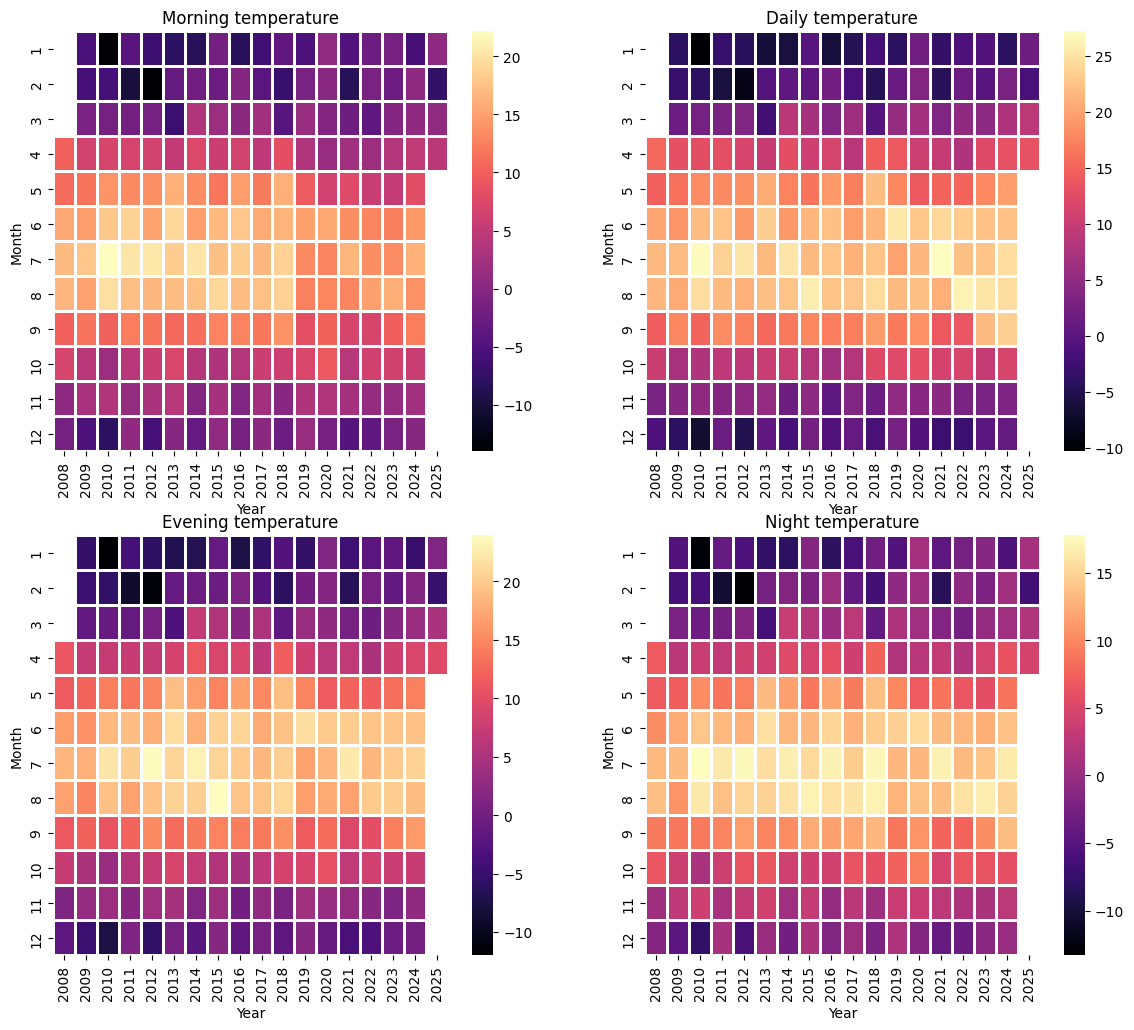

In [75]:
plt.figure(figsize=(14,12))
plt.subplot(2, 2, 1)
plt.title('Morning temperature')
sns.heatmap(df_temperature.pivot_table(index='Month', columns='Year', values='Morning temperature'), cmap='magma',linecolor='white',linewidths=1)
plt.subplot(2, 2, 2)
plt.title('Daily temperature')
sns.heatmap(df_temperature.pivot_table(index='Month', columns='Year', values='Daily temperature'), cmap='magma',linecolor='white',linewidths=1)
plt.subplot(2, 2, 3)
plt.title('Evening temperature')
sns.heatmap(df_temperature.pivot_table(index='Month', columns='Year', values='Evening temperature'), cmap='magma',linecolor='white',linewidths=1)
plt.subplot(2, 2, 4)
plt.title('Night temperature')
sns.heatmap(df_temperature.pivot_table(index='Month', columns='Year', values='Night temperature'), cmap='magma',linecolor='white',linewidths=1)

**Построение прогнозируещей модели**  

Для построения прогноза температуры на ближайшие дни необходимо проверить: является ли ряд стационарным

In [76]:
print('Результат теста:')
df_result = adfuller(df_temperature['Daily temperature'])
df_labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used', 'Critical Values:']
for result_value, label in zip(df_result, df_labels):
    print(label + ' : ' + str(result_value))

if df_result[1] <= 0.05:
    print("Сильные доказательства против нулевой гипотезы, ряд является стационарным.")
else:
    print("Слабые доказательства против нулевой гипотезы, ряд не является стационарным.")

Результат теста:
ADF Test Statistic : -0.838436273421131
p-value : 0.8075702296605763
#Lags Used : 34
Number of Observations Used : 6153
Critical Values: : {'1%': np.float64(-3.431413226100799), '5%': np.float64(-2.86200985034572), '10%': np.float64(-2.5670200985739107)}
Слабые доказательства против нулевой гипотезы, ряд не является стационарным.


Построим график скользящего среднего и стандартного отклонения, чтобы определить, какие преобразования нужны для стационарности

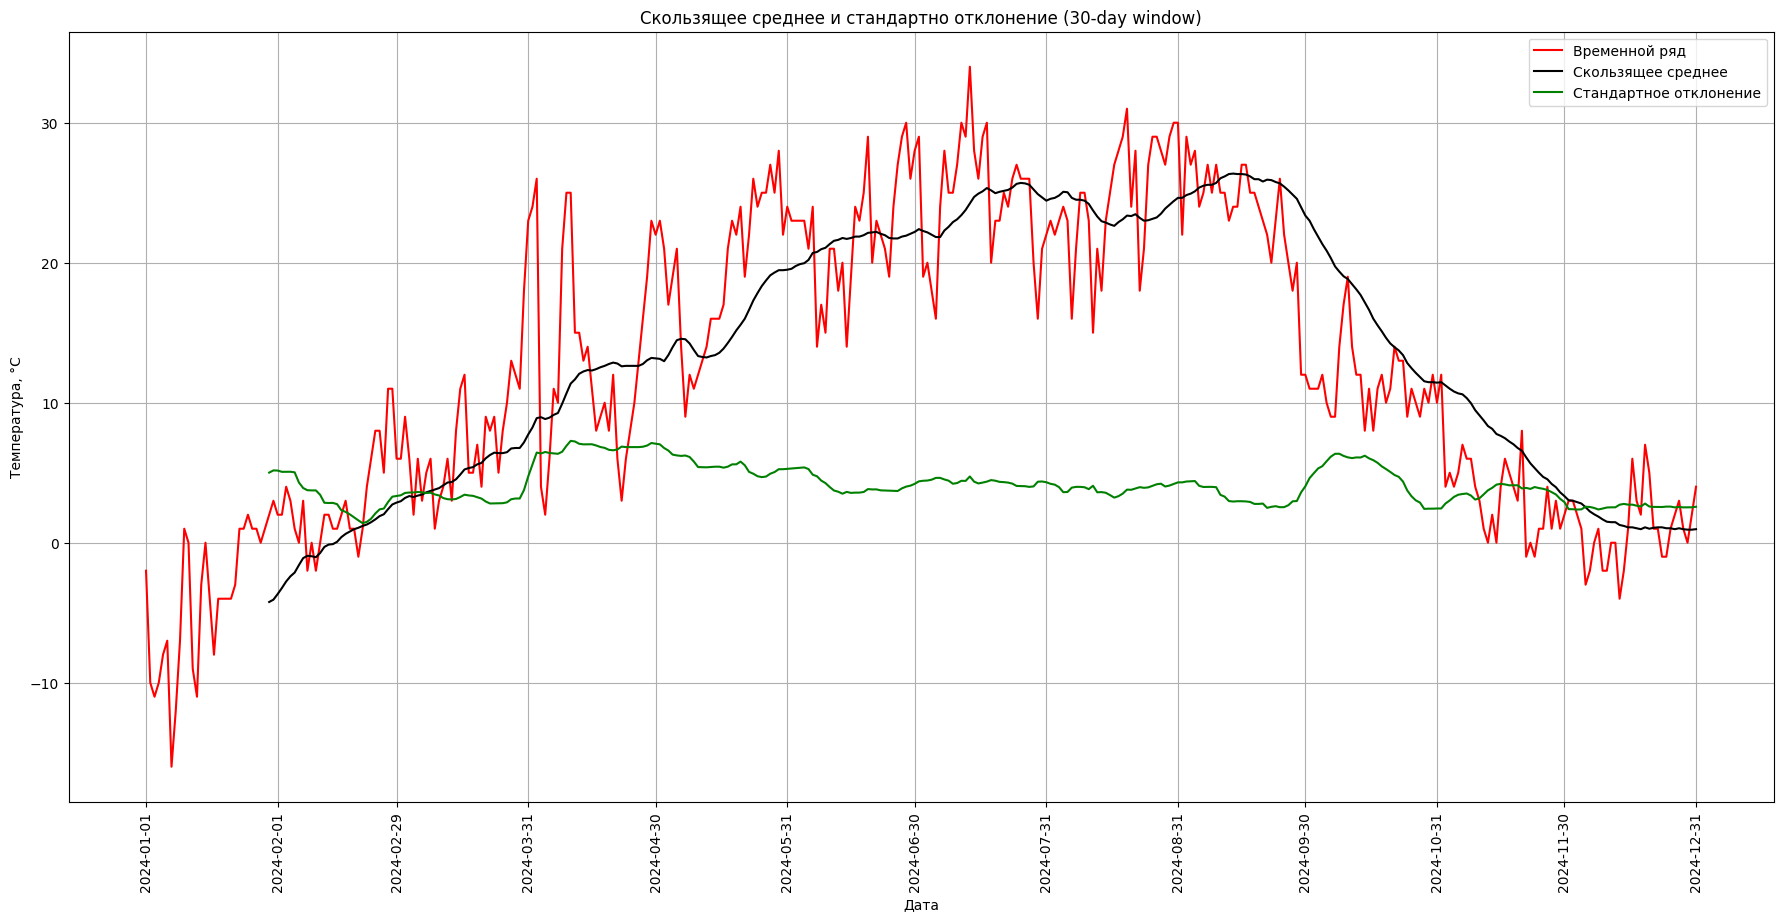

In [77]:
rolmean = df_temperature.loc[df_temperature['Year']==2024,'Daily temperature'].rolling(30).mean()
rolstd = df_temperature.loc[df_temperature['Year']==2024,'Daily temperature'].rolling(30).std()
plt.figure(figsize=(22,10))
orig = plt.plot(df_temperature.loc[df_temperature['Year']==2024, 'Date'], df_temperature.loc[df_temperature['Year']==2024, 'Daily temperature'], color='red', label='Временной ряд')
mean = plt.plot(df_temperature.loc[df_temperature['Year']==2024, 'Date'], rolmean, color='black', label='Скользящее среднее')
std = plt.plot(df_temperature.loc[df_temperature['Year']==2024, 'Date'], rolstd, color='green', label='Стандартное отклонение')
plt.xticks(rotation=90)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.xlabel('Дата')
plt.ylabel('Температура, °C')
plt.title('Скользящее среднее и стандартно отклонение (30-day window)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
df_temperature["Seasonal_diff"] = df_temperature["Daily temperature"].diff(periods=12).dropna()

In [100]:
df_temperature.loc[df_temperature['Year'] == 2024]

,Date,Morning temperature,Daily temperature,Evening temperature,Night temperature,Year,YM,Month,Seasonal_diff
1,2024-01-01,-1,-2,-4,-1,2024,2024-01,1,NaN
18,2024-01-02,-7,-10,-11,-6,2024,2024-01,1,-10.0
35,2024-01-03,-12,-11,-11,-12,2024,2024-01,1,-12.0
52,2024-01-04,-11,-10,-11,-11,2024,2024-01,1,-7.0
69,2024-01-05,-11,-8,-5,-11,2024,2024-01,1,-3.0
...,...,...,...,...,...,...,...,...,...
6103,2024-12-27,1,3,2,1,2024,2024-12,12,1.0
6120,2024-12-28,0,1,1,0,2024,2024-12,12,1.0
6137,2024-12-29,0,0,1,2,2024,2024-12,12,1.0
6154,2024-12-30,1,2,3,1,2024,2024-12,12,7.0


In [149]:
result = adfuller(df_temperature["Seasonal_diff"].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
if result[1] <= 0.05:
    print("Сильные доказательства против нулевой гипотезы, ряд является стационарным.")
else:
    print("Слабые доказательства против нулевой гипотезы, ряд не является стационарным.")

ADF Statistic: -14.627818147011096
p-value: 3.793972072658069e-27
Сильные доказательства против нулевой гипотезы, ряд является стационарным.


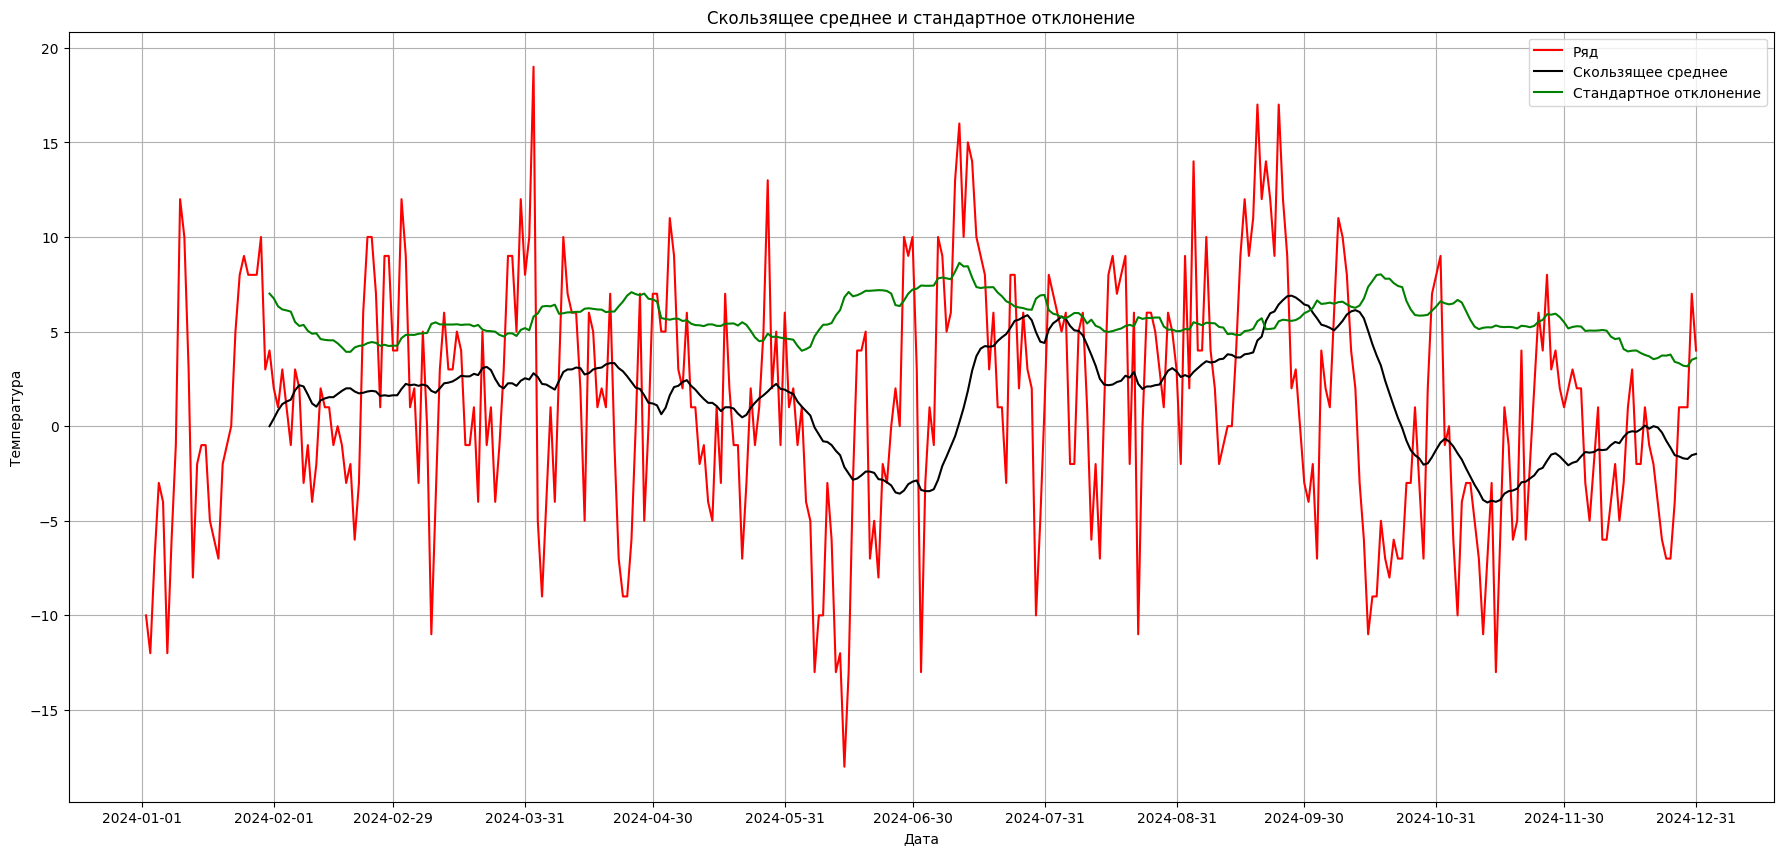

In [ ]:
rolmean = df_temperature.loc[df_temperature['Year']==2024, 'Seasonal_diff'].rolling(30).mean()
rolstd = df_temperature.loc[df_temperature['Year']==2024, 'Seasonal_diff'].rolling(30).std()
plt.figure(figsize=(22,10))
orig = plt.plot(df_temperature.loc[df_temperature['Year']==2024, 'Date'], df_temperature.loc[df_temperature['Year']==2024, 'Seasonal_diff'], color='red', label='Ряд')
mean = plt.plot(df_temperature.loc[df_temperature['Year']==2024, 'Date'], rolmean, color='black', label='Скользящее среднее')
std = plt.plot(df_temperature.loc[df_temperature['Year']==2024, 'Date'], rolstd, color='green', label='Стандартное отклонение')
plt.xlabel('Дата')
plt.ylabel('Температура')
plt.title('Скользящее среднее и стандартное отклонение')
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.grid(True)
plt.show()

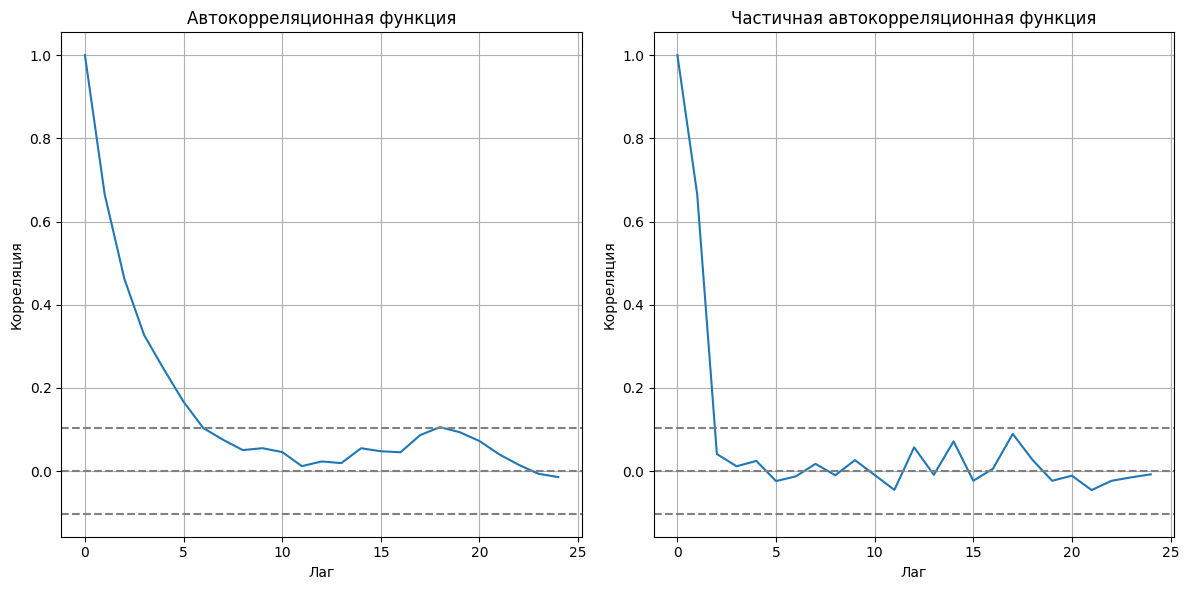

In [142]:
#ACF & PACF
lag_acf = sm.tsa.acf(df_temperature['Seasonal_diff'].dropna(), nlags=24, fft=False)
lag_pacf = sm.tsa.pacf(df_temperature['Seasonal_diff'].dropna(), nlags=24, method='ols')

plt.figure(figsize=(12,6))

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_temperature['Seasonal_diff'].dropna())),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_temperature['Seasonal_diff'].dropna())),linestyle='--',color='gray')
plt.title('Автокорреляционная функция')
plt.xlabel('Лаг')
plt.ylabel('Корреляция')
plt.grid(True)

# PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_temperature['Seasonal_diff'].dropna())),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_temperature['Seasonal_diff'].dropna())),linestyle='--',color='gray')
plt.title('Частичная автокорреляционная функция')
plt.xlabel('Лаг')
plt.ylabel('Корреляция')
plt.grid(True)
plt.tight_layout()

d:\weather_prediction\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\weather_prediction\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\weather_prediction\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


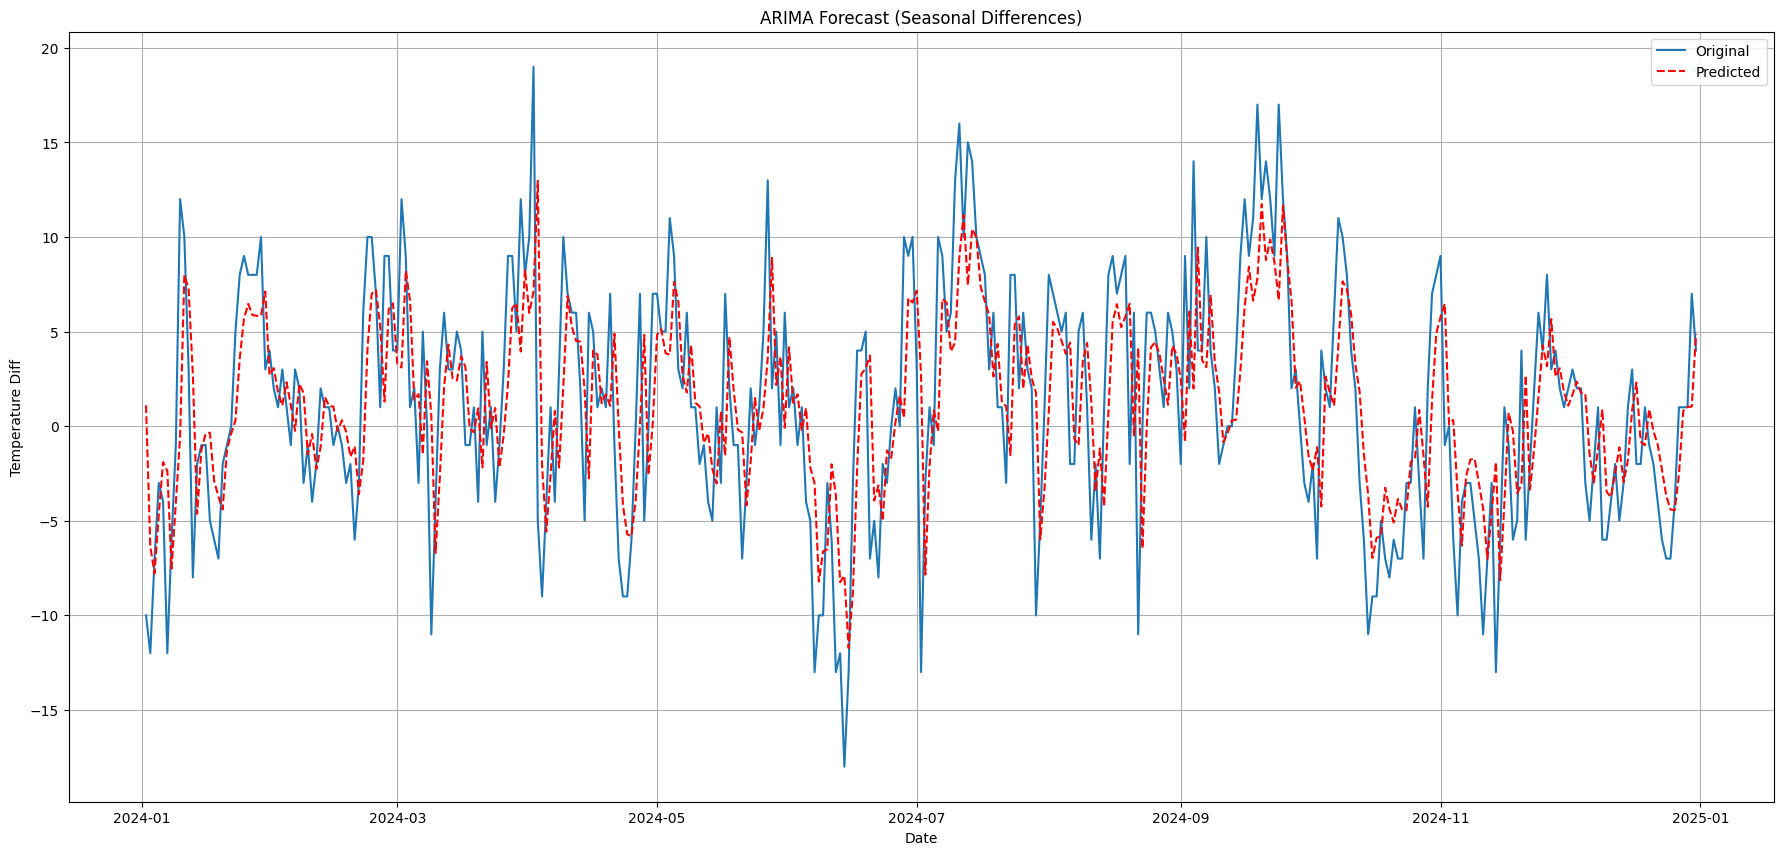

In [ ]:
data_2024 = df_temperature.loc[df_temperature['Year'] == 2024, ['Date', 'Seasonal_diff']].dropna()
data_2024['Date'] = pd.to_datetime(data_2024['Date'])
# Убедимся, что данные имеют временной индекс
if not isinstance(data_2024.index, pd.DatetimeIndex):
    data_2024.set_index('Date', inplace=True)

model = ARIMA(data_2024['Seasonal_diff'], order=(1,0,1))
model_fit = model.fit()

forecast = model_fit.predict(start= data_2024.index[0], end=data_2024.index[-1])

plt.figure(figsize=(22, 10))
plt.plot(data_2024.index, data_2024['Seasonal_diff'], 
         label="Original")

# Прогноз (используем индекс прогноза)
plt.plot(forecast.index, forecast.values, 
         label="Predicted", color='red', linestyle='--')
plt.title("ARIMA Forecast (Seasonal Differences)")
plt.xlabel("Date")
plt.ylabel("Temperature Diff")
plt.legend()
plt.grid()
plt.show()